## Tensorflow Crowd Counting for Cell Density

Ben Halligan 

- Using the INS1_BF dataset
- Based on [this](https://yangliang.github.io/pdf/sp055u.pdf) CNN


## How to fix

- <s>Shuffle the data in the generators to mix up filters</s>
- Add a dropout to remove non-important connections
- Increase the filter size to capture more the of the image in earlier layers
- <s>Find out how to enable `tensorflow-gpu` with cuda-11.1 so I can have my life back</s>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from PIL import Image


import pathlib

dataset_path = 'data/INS1_BF/'
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [2]:
# augment data to find more cells to count

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# create preview
############################################################
outpath = 'out/test.jpg'
img = Image.open('data/INS1_BF/2000/3765_M20_T0001F001L01A01Z01C01.tiff')
img.show()
############################################################

In [3]:
# create train and test sets

# train
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(200,200),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

# test
test_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(200,200),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

/home/ben/.local/lib/python3.6/site-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


Found 312 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [4]:
# new model based on paper

num_classes = 6 # can't change
batch_size = 32 # chanagable
h, w = (200, 200) # height and width
cc = 1 # color channel, 1 cause, you know... G R A Y

model = None

model = Sequential([
    layers.experimental.preprocessing.Resizing(h,w),
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(h, w, cc)),
    layers.Conv2D(100, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

In [12]:
model.build((None, 2000, 2000, 1))

mse = tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")

model.compile(optimizer='adam',
             loss=mse,
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 200, 200, None)    0         
_________________________________________________________________
rescaling (Rescaling)        (None, 200, 200, None)    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 100)     2600      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 100)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      57664     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        1

In [13]:
num_epochs = 25
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // batch_size,
    epochs=num_epochs
)

Epoch 1/25
9/9 [==============================] - 1s 161ms/step - loss: 0.1452 - accuracy: 0.8333 - val_loss: 0.1391 - val_accuracy: 0.8333
Epoch 2/25
9/9 [==============================] - 1s 144ms/step - loss: 0.1401 - accuracy: 0.8333 - val_loss: 0.1392 - val_accuracy: 0.8333
Epoch 3/25
9/9 [==============================] - 1s 141ms/step - loss: 0.1396 - accuracy: 0.8333 - val_loss: 0.1390 - val_accuracy: 0.8333
Epoch 4/25
9/9 [==============================] - 1s 142ms/step - loss: 0.1395 - accuracy: 0.8333 - val_loss: 0.1389 - val_accuracy: 0.8333
Epoch 5/25
9/9 [==============================] - 1s 143ms/step - loss: 0.1394 - accuracy: 0.8333 - val_loss: 0.1390 - val_accuracy: 0.8333
Epoch 6/25
9/9 [==============================] - 1s 143ms/step - loss: 0.1393 - accuracy: 0.8333 - val_loss: 0.1389 - val_accuracy: 0.8333
Epoch 7/25
9/9 [==============================] - 1s 146ms/step - loss: 0.1394 - accuracy: 0.8333 - val_loss: 0.1389 - val_accuracy: 0.8333
Epoch 8/25
9/9 [====

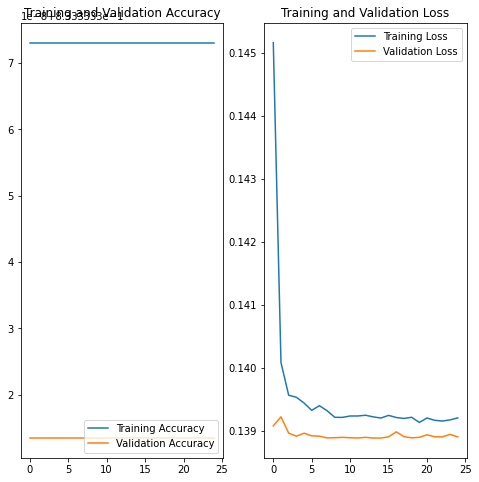

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

```
# build a simple model (not the one in the paper)

num_classes = 6 # can't change
batch_size = 32 # chanagable
h, w = (IMG_SIZE, IMG_SIZE) # height and width
cc = 1 # color channel, 1 cause, you know... G R A Y

model = Sequential([
#     resize_rescale,
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(h, w, cc)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(4, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

num_epochs = 25
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // batch_size,
    epochs=num_epochs
)

# graph the terrible results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

```

Example `model.fit_generator()`

```
model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs)
```
